In [1]:
import os
import glob
import time
import copy

import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms, ops

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

### Utility Functions

In [2]:
def velocities_from_boxes(boxes_prev, boxes):
    """Computes bounding box velocities.
    
    Args:
        boxes_prev (`torch.Tensor`): Bounding boxes in previous frame. Shape [B, N, 4]
            where B is the batch size and N the number of bounding boxes.
            
        boxes (`torch.Tensor`): Bounding boxes in current frame. Shape [B, N, 4]
            where B is the batch size and N the number of bounding boxes.
            
    Returns:
        (`torch.Tensor`) velocities of box coordinates in current frame. Shape [B, N, 4].
        
    Ensure that ordering of boxes in both tensors is consistent and that the number of boxes
    is the same.
    """
    x = boxes[:, 0]
    y = boxes[:, 1]
    w = boxes[:, 2]
    h = boxes[:, 3]
    x_p = boxes_prev[:, 0]
    y_p = boxes_prev[:, 1]
    w_p = boxes_prev[:, 2]
    h_p = boxes_prev[:, 3] 
    v_x = (1 / w_p * (x - x_p)).unsqueeze(-1)
    v_y = (1 / h_p * (y - y_p)).unsqueeze(-1)
    v_w = (torch.log(w / w_p)).unsqueeze(-1)
    v_h = (torch.log(h / h_p)).unsqueeze(-1) 
    return torch.cat([v_x, v_y, v_w, v_h], -1)

In [3]:
def box_from_velocities(boxes_prev, velocities):
    """Computes bounding boxes from previous boxes and velocities.
    
    Args:
        boxes_prev (`torch.Tensor`): Bounding boxes in previous frame. Shape [B, N, 4] 
            where B is the batch size and N the number of bounding boxes.
            
        velocities (`torch.Tensor`): Box velocities in current frame. Shape [B, N, 4] 
        where B is the batch size and N the number of bounding boxes.
            
    Returns:
        (`torch.Tensor`) Bounding boxes in current frame. Shape [B, N, 4].
        
    Ensure that ordering of boxes and velocities in both tensors is consistent that is
    box in row i should correspond to velocities in row i.
    """
    x_p = boxes_prev[:, 0]
    y_p = boxes_prev[:, 1]
    w_p = boxes_prev[:, 2]
    h_p = boxes_prev[:, 3]
    v_x = velocities[:, 0]
    v_y = velocities[:, 1]
    v_w = velocities[:, 2]
    v_h = velocities[:, 3]
    x = (w_p * v_x + x_p).unsqueeze(-1)
    y = (h_p * v_y + y_p).unsqueeze(-1)
    w = (w_p * torch.exp(v_w)).unsqueeze(-1)
    h = (h_p * torch.exp(v_h)).unsqueeze(-1)
    return torch.cat([x, y, w, h], -1)

### Data Loader

247
tensor([[[[ 0.0000,  0.0000,  0.0000,  ..., -0.2500,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2500, -0.2500, -0.2500],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.2500],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -8.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000, -0.5000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]])
tensor([[ 248.,  944.,  421.,  160.,  426.],
        [ 248., 1051.,  487.,   39.,  105.],
       

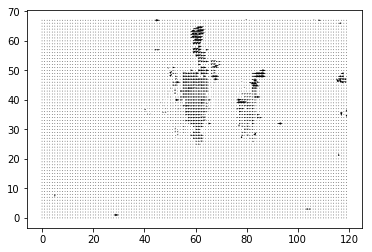

248
tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.5000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.2500,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.2500,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 13.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 13.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.7500,  0.0000, 13.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]])
tensor([[ 249.,  946.,  421.,  166.,  426.],
        [ 249., 1051.,  487.,   39.,  105.],
       

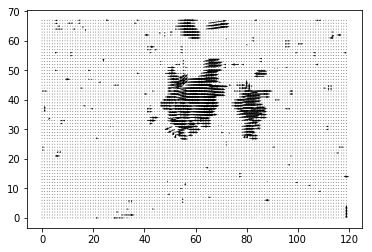

249
tensor([[[[-3.0472e+16,  4.5630e-41, -3.0472e+16,  ...,  2.7539e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  2.7500e+00,  0.0000e+00,  ...,  2.9883e+00,
            0.0000e+00,  2.4219e+00],
          [ 0.0000e+00,  2.9883e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  1.9062e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.6250e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  1.8125e+00,  0.0000e+00,  ...,  1.9375e+00,
            0.0000e+00,  1.6250e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.6250e+00,
            0.0000e+00, -1.6250e+00]],

         [[ 0.0000e+00,  1.9062e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.7500e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  1.7500e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
 

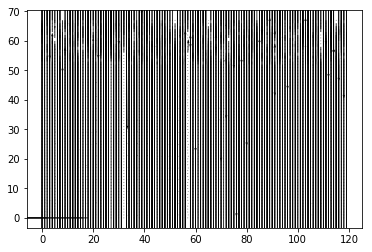

250
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[ 251.,  950.,  421.,  172.,  428.],
        [ 251., 1051.,  487.,   39.,  105.],
        [ 251., 1086.,  484.,   39.,  112.],
        [ 251., 1117.,  450.,   38.,   99.],
        [ 251.,  982.,  447.,   31.,   88.],
        [ 251., 1098.,  437.,   38.,  109.],
        [ 251.,  972.,  445.,   36.,  114.],
        [ 251.,  914.,  407.,  156.,  629.],
        [ 251., 1219.,  438.,  194.,  368.],
        [ 251.,  793.,  434.,  137.,  446.],
       

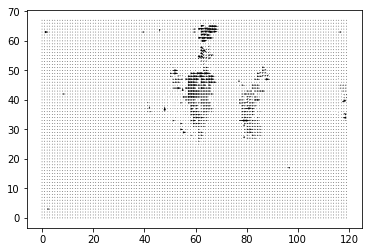

251
tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.2500],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  8.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]])
tensor([[ 252.,  952.,  422.,  171.,  429.],
        [ 252., 1051.,  487.,   39.,  105.],
       

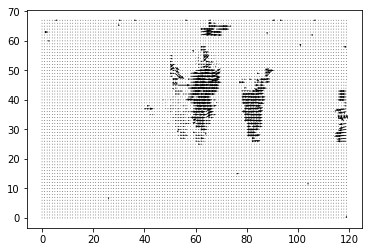

252
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[ 253.,  954.,  423.,  170.,  430.],
        [ 253., 1051.,  487.,   39.,  105.],
        [ 253., 1086.,  484.,   39.,  112.],
        [ 253., 1117.,  450.,   38.,   99.],
        [ 253.,  981.,  447.,   31.,   87.],
        [ 253., 1098.,  437.,   38.,  109.],
        [ 253.,  973.,  446.,   35.,  113.],
        [ 253.,  920.,  407.,  158.,  631.],
        [ 253., 1223.,  438.,  198.,  370.],
        [ 253.,  797.,  434.,  136.,  452.],
       

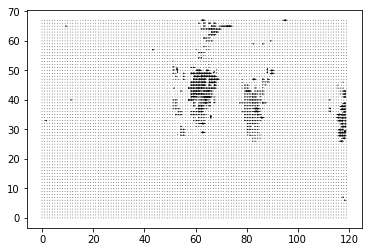

In [41]:
class MotionVectorDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, mode, keyframe_interval=10, pad_num_boxes=52, window_length=3):
        self.mode = mode
        self.keyframe_interval = keyframe_interval
        self.pad_num_boxes = pad_num_boxes
        self.window_length = window_length
        assert self.window_length > 0, "window length must be 1 or greater"
        data_file = os.path.join(root_dir, "preprocessed", mode, "data.pkl")
        self.data = pickle.load(open(data_file, "rb"))
        
        # remove entries so that an integer number of sequences of window length can be generated
        if self.window_length > 1:
            lengths_file = os.path.join(root_dir, "preprocessed", mode, "lengths.pkl")
            lengths = pickle.load(open(lengths_file, "rb"))
            lenghts_cumsum = np.cumsum(lengths)
            for lenght, lenght_cumsum in zip(reversed(lengths), reversed(lenghts_cumsum)):
                remainder = lenght % self.window_length  # e.g. 2
                for r in range(remainder):
                    self.data.pop(lenght_cumsum-1-r)
                    
            
    def __len__(self):
        return len(self.data) - 1  # -1 is needed because of idx+1 in __getitem__
        
        
    def __getitem__(self, idx):
        
        if self.mode == "train" or self.mode == "val":
            
            motion_vectors_agg = []
            boxes_agg = []
            boxes_prev_agg = []
            velocities_agg = []
            num_boxes_mask_agg = []
            
            # for every sample we expect 3 (window_length) entries
            for ws in range(self.window_length):  # ws = 0, 1, 2
            
                motion_vectors = self.data[idx + ws + 1]["motion_vectors"]

                frame_idx = self.data[idx + ws + 1]["frame_idx"]
                gt_ids = self.data[idx + ws + 1]["gt_ids"]
                gt_boxes = self.data[idx + ws + 1]["gt_boxes"]
                gt_ids_prev = self.data[idx + ws]["gt_ids"]
                gt_boxes_prev = self.data[idx + ws]["gt_boxes"]

                # find boxes which occured in the last frame
                _, idx_1, idx_0 = np.intersect1d(gt_ids, gt_ids_prev, assume_unique=True, return_indices=True)
                boxes = torch.from_numpy(gt_boxes[idx_1])
                boxes_prev = torch.from_numpy(gt_boxes_prev[idx_0])
                velocities = velocities_from_boxes(boxes_prev, boxes)

                # insert frame index into boxes
                num_boxes = (boxes.shape)[0]
                boxes_prev_tmp = torch.zeros(num_boxes, 5)
                boxes_prev_tmp[:, 1:5] = boxes_prev
                boxes_prev_tmp[:, 0] = torch.full((num_boxes,), frame_idx)
                boxes_prev = boxes_prev_tmp

                # pad boxes_prev to the same global length (for MOT17 this is 52)
                boxes_prev_padded = torch.zeros(self.pad_num_boxes, 5)
                boxes_prev_padded[:num_boxes, :] = boxes_prev
                boxes_prev = boxes_prev_padded
                
                # similarly pad boxes
                boxes_padded = torch.zeros(self.pad_num_boxes, 4)
                boxes_padded[:num_boxes, :] = boxes
                boxes = boxes_padded

                # similarly pad velocites
                velocities_padded = torch.zeros(self.pad_num_boxes, 4)
                velocities_padded[:num_boxes, :] = velocities
                velocities = velocities_padded

                # create a mask to revert the padding at a later stage
                num_boxes_mask = torch.zeros(self.pad_num_boxes,)
                num_boxes_mask[0:num_boxes] = torch.ones(num_boxes,)
                
                motion_vectors_agg.append(motion_vectors.float())
                boxes_agg.append(boxes.float())
                boxes_prev_agg.append(boxes_prev.float())
                velocities_agg.append(velocities.float())
                num_boxes_mask_agg.append(num_boxes_mask.bool())
                
            # convert aggregate lists to torch tensors
            if self.window_length > 1:
                motion_vectors_agg = [t.unsqueeze(0) for t in motion_vectors_agg]
                boxes_agg = [t.unsqueeze(0) for t in boxes_agg]
                boxes_prev_agg = [t.unsqueeze(0) for t in boxes_prev_agg]
                velocities_agg = [t.unsqueeze(0) for t in velocities_agg]
                num_boxes_mask_agg = [t.unsqueeze(0) for t in num_boxes_mask_agg]
                
            motion_vectors_ret = torch.cat(motion_vectors_agg, axis=0)
            boxes_ret = torch.cat(boxes_agg, axis=0)
            boxes_prev_ret = torch.cat(boxes_prev_agg, axis=0)
            velocities_ret = torch.cat(velocities_agg, axis=0)
            num_boxes_mask_ret = torch.cat(num_boxes_mask_agg, axis=0)
            
            # TODO: remove I frames
            
            return motion_vectors_ret, boxes_prev_ret, velocities_ret, num_boxes_mask_ret, boxes_ret
        

datasets = {x: MotionVectorDataset(root_dir='../benchmark/MOT17', window_length=1, mode=x) for x in ["train", "val", "test"]}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=1, shuffle=False, num_workers=1) for x in ["train", "val", "test"]}

for step, (motion_vectors, boxes_prev, velocities, num_boxes_mask, boxes) in enumerate(dataloaders["train"]):
    if step > 246:
        print(step)
        #print(motion_vectors.shape)
        #print(boxes_prev.shape)
        #print(boxes.shape)    
        #print(velocities.shape)
        #print(num_boxes_mask.shape)
        print(motion_vectors)
        print(boxes_prev[num_boxes_mask])
        print(boxes[num_boxes_mask])    
        print(velocities[num_boxes_mask])

        plt.quiver(motion_vectors[0, 0, :, :], motion_vectors[0, 1, :, :], scale=1000)
        plt.show()
    
    if step > 251:
        break

### Propagation Network

In [23]:
class PropagationNetwork(nn.Module):
    def __init__(self):
        super(PropagationNetwork, self).__init__()
        
        self.POOLING_SIZE = 7  # the ROIs are split into m x m regions
        self.FIXED_BLOCKS = 1
        
        self.base = torchvision.models.resnet18(pretrained=True)
        
        # change number of input channels from 3 to 2
        #self.base.conv1.in_channels = 2
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
         
        # remove fully connected and avg pool layers
        self.base = nn.Sequential(*list(self.base.children())[:-2])
        
        # change stride to 1 in conv5 block
        #self.base[5][0].conv1 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), dilation=2, padding=(1, 1), bias=False)
        #self.base[5][0].conv2 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), dilation=2, padding=(1, 1), bias=False)
        
        #self.conv1 = nn.Conv2d(512, 4, kernel_size=(1, 1), stride=(1, 1))
        self.conv1 = nn.Conv2d(512, 4*self.POOLING_SIZE*self.POOLING_SIZE, kernel_size=(1, 1), stride=(1, 1), padding=0, bias=False)
        
        
        #def set_bn_fix(m):
        #    classname = m.__class__.__name__
        #    print(classname)
        #    if classname.find('BatchNorm2d') != -1:
        #        for p in m.parameters(): p.requires_grad = False
        #
        #self.base.apply(set_bn_fix)
        
        assert (0 <= self.FIXED_BLOCKS <= 4) # set this value to 0, so we can train all blocks
        if self.FIXED_BLOCKS >= 4: # fix all blocks
            for p in self.base[10].parameters(): p.requires_grad = False
        if self.FIXED_BLOCKS >= 3: # fix first 3 blocks
            for p in self.base[8].parameters(): p.requires_grad = False
        if self.FIXED_BLOCKS >= 2: # fix first 2 blocks
            for p in self.base[6].parameters(): p.requires_grad = False
        if self.FIXED_BLOCKS >= 1: # fix first 1 block
            for p in self.base[4].parameters(): p.requires_grad = False
        
        #print([p.requires_grad for p in self.base.parameters()])
        
        
        #print(list(self.base.children())[5][0].conv1)
        #print(list(zip(list(self.children()), [p.requires_grad for p in self.base.parameters()])))
        
    def forward(self, motion_vectors, boxes_prev, num_boxes_mask):
        #print(boxes_prev)
        #print("boxes_prev:", boxes_prev.shape)
        #print("motion_vectors:", motion_vectors.shape)
        x = self.base(motion_vectors)
        #print("after ResNet18:", x.shape)
        x = self.conv1(x)
        x = F.relu(x)
        #print("after conv1", x.shape)
        
        boxes_prev = self._change_box_format(boxes_prev)
        boxes_prev = boxes_prev[num_boxes_mask]
        boxes_prev = boxes_prev.view(-1, 5)
        # offset frame_idx so that it corresponds to batch index
        boxes_prev[..., :, 0] = boxes_prev[..., :, 0] - boxes_prev[..., 0, 0]
        
        # compute ratio of input size to size of base output
        spatial_scale = x.shape[-1] / (motion_vectors.shape)[-1]
        print(spatial_scale)
        x = torchvision.ops.ps_roi_pool(x, boxes_prev, output_size=(self.POOLING_SIZE, self.POOLING_SIZE), spatial_scale=spatial_scale)
        #print("after roi_pool", x.shape)
        velocities_pred = x.mean(-1).mean(-1)
        #print("after averaging", velocities_pred.shape)
        
        return velocities_pred
    
    
    def _change_box_format(self, boxes):
        """Change format of boxes from [x, y, w, h] to [x1, y1, x2, y2]."""
        boxes[..., 0] = boxes[..., 0]
        boxes[..., 1] = boxes[..., 1]
        boxes[..., 2] = boxes[..., 2]
        boxes[..., 3] = boxes[..., 1] + boxes[..., 3]
        boxes[..., 4] = boxes[..., 2] + boxes[..., 4]
        return boxes

### Training loop

In [6]:
def train(model, criterion, optimizer, scheduler, num_epochs=2):
    tstart = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    pickle.dump(best_model_wts, open("models/best_model.pkl", "wb"))
    best_loss = 99999.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0

            for step, (motion_vectors, boxes_prev, velocities, num_boxes_mask) in enumerate(dataloaders[phase]):
                motion_vectors = motion_vectors.to(device)
                boxes_prev = boxes_prev.to(device)
                velocities = velocities.to(device)
                num_boxes_mask = num_boxes_mask.to(device)
                
                velocities = velocities[num_boxes_mask]
                velocities = velocities.view(-1, 4)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    velocities_pred = model(motion_vectors, boxes_prev, num_boxes_mask)
                    
                    loss = criterion(velocities_pred, velocities)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                       
                running_loss += loss.item() * motion_vectors.size(0)
                
            epoch_loss = running_loss / len(datasets[phase])
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            if phase == "val":
                model_wts = copy.deepcopy(model.state_dict())
                pickle.dump(best_model_wts, open("models/model_{:04d}.pkl".format(epoch), "wb"))
            
            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                pickle.dump(best_model_wts, open("models/best_model.pkl", "wb"))
                
    time_elapsed = time.time() - tstart
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Lowest validation loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
datasets = {x: MotionVectorDataset(root_dir='../benchmark/MOT17', mode=x) for x in ["train", "val", "test"]}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=2, shuffle=False, num_workers=4) for x in ["train", "val", "test"]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = PropagationNetwork()
model = model.to(device)

criterion = nn.SmoothL1Loss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
best_model = train(model, criterion, optimizer, scheduler, num_epochs=60)

Epoch 0/59
train Loss: 0.0007
val Loss: 0.0015
Epoch 1/59
train Loss: 0.0007
val Loss: 0.0015
Epoch 2/59
train Loss: 0.0007
val Loss: 0.0015
Epoch 3/59
train Loss: 0.0007
val Loss: 0.0015
Epoch 4/59
train Loss: 0.0007
val Loss: 0.0015
Epoch 5/59
train Loss: 0.0007
val Loss: 0.0015
Epoch 6/59
train Loss: 0.0007
val Loss: 0.0015
Epoch 7/59
train Loss: 0.0007
val Loss: 0.0015
Epoch 8/59
train Loss: 0.0007
val Loss: 0.0015
Epoch 9/59
